# Comparación: SQL vs NoSQL (3 escenarios simulados)

In [4]:
# Imports y configuración visual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

# Semilla para reproducibilidad
np.random.seed(42)

# Mostrar versiones (opcional)
import sys
print("Pandas:", pd.__version__, "Numpy:", np.__version__)


Pandas: 2.2.2 Numpy: 2.0.2


## Generación de datos sintéticos
Vamos a crear un dataset base de **~300 animes** (id, title, category, episodes, rating, members).
Este dataset será la "tabla" que usaremos para simular los tres escenarios.


In [5]:
# Parámetros
n = 300  # filas (entre 100 y 500 según requisito)

# Campos base
titles = [f"Anime_{i}" for i in range(1, n+1)]
categories = ['Action','Drama','Comedy','Sports','Sci-Fi','SliceOfLife']
cat_probs = [0.25,0.2,0.2,0.15,0.12,0.08]  # suma 1

# Episodios: mezcla corta/mediana/larga
length_type = np.random.choice(['short','medium','long'], size=n, p=[0.6,0.3,0.1])
episodes = []
for t in length_type:
    if t == 'short':
        episodes.append(np.random.randint(1,51))
    elif t == 'medium':
        episodes.append(np.random.randint(51,201))
    else:
        episodes.append(np.random.randint(201,1800))

# Rating y members
rating = np.clip(np.random.normal(7.0, 0.9, n), 1.0, 10.0).round(2)
members = np.random.randint(1000, 2_000_000, n)

# Construir DataFrame (simula una tabla SQL con esquema fijo)
df_sql = pd.DataFrame({
    "id": range(1, n+1),
    "title": titles,
    "category": np.random.choice(categories, size=n, p=cat_probs),
    "episodes": episodes,
    "rating": rating,
    "members": members
})

# Vista rápida
df_sql.head()


,id,title,category,episodes,rating,members
0,1,Anime_1,Action,45,7.31,261910
1,2,Anime_2,Comedy,1192,8.72,1072812
2,3,Anime_3,Drama,166,7.29,88955
3,4,Anime_4,Sci-Fi,30,7.17,1790450
4,5,Anime_5,Sports,47,8.44,628433


## 1) SQL (estructura rígida)
Piensa en SQL como **una hoja de cálculo grande**: todas las filas tienen las mismas columnas (como hojas con los mismos campos impresos). Si quieres agregar una columna nueva a la base real, en muchos sistemas necesitas hacer un `ALTER TABLE` (cambiar el formulario impreso).
Veremos estadísticas y qué pasa si "intentamos" agregar un nuevo atributo.


In [6]:
# Resumen del "modelo SQL"
print("Filas:", len(df_sql))
print("\nTipos y columnas:")
display(df_sql.info())
print("\nEstadísticas numéricas:")
display(df_sql.describe().round(2))

# Distribución por categoría (tabla)
display(df_sql['category'].value_counts().rename_axis('category').reset_index(name='count'))


Filas: 300

Tipos y columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   title     300 non-null    object 
 2   category  300 non-null    object 
 3   episodes  300 non-null    int64  
 4   rating    300 non-null    float64
 5   members   300 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 14.2+ KB


None


Estadísticas numéricas:


,id,episodes,rating,members
count,300.00,300.00,300.00,300.00
mean,150.50,157.93,7.10,1006858.61
std,86.75,329.53,1.03,565815.09
min,1.00,1.00,3.79,22172.00
25%,75.75,22.00,6.44,541215.25
50%,150.50,41.00,7.16,1006640.50
75%,225.25,140.50,7.73,1525165.75
max,300.00,1750.00,9.86,1997055.00


,category,count
0,Action,76
1,Comedy,64
2,Drama,46
3,Sports,45
4,Sci-Fi,43
5,SliceOfLife,26


In [7]:
# En una base SQL real: ALTER TABLE. En pandas podemos añadir una columna (sería NULL por defecto para viejas filas).
df_sql_sqlstyle = df_sql.copy()
df_sql_sqlstyle['spin_off'] = np.nan  # simula que la columna existe pero está vacía para la mayoría

# Mostrar efecto
display(df_sql_sqlstyle.head())
print("Nota: en SQL esto requiere modificar esquema; aquí en pandas lo vemos como columna con valores nulos.")


,id,title,category,episodes,rating,members,spin_off
0,1,Anime_1,Action,45,7.31,261910,NaN
1,2,Anime_2,Comedy,1192,8.72,1072812,NaN
2,3,Anime_3,Drama,166,7.29,88955,NaN
3,4,Anime_4,Sci-Fi,30,7.17,1790450,NaN
4,5,Anime_5,Sports,47,8.44,628433,NaN


Nota: en SQL esto requiere modificar esquema; aquí en pandas lo vemos como columna con valores nulos.


## 2) NoSQL documental (heterogéneo)
Analogía: **una baraja de cartas** en la que cada carta puede tener distinta información: algunas tienen dígitos extras, otras no. No hay una "ficha impresa" obligatoria; cada documento puede llevar campos diferentes.
Veremos documentos donde algunos registros traen campos extra (OVA, producer, spin_off) y otros no.


In [8]:
# Convertimos filas a documentos y agregamos aleatoriamente campos distintos a cada documento
docs_hetero = []
for _, row in df_sql.sample(frac=1.0, random_state=1).iterrows():
    doc = {
        "id": int(row.id),
        "title": row.title,
        "episodes": int(row.episodes),
        "rating": float(row.rating),
        "category": row.category
    }
    # Aleatoriamente añadir campos distintos
    if np.random.rand() < 0.18:
        doc["OVA"] = True
    if np.random.rand() < 0.12:
        doc["spin_off_title"] = f"{row.title} - SideStory"
    if np.random.rand() < 0.10:
        doc["producer"] = np.random.choice(["Studio A","Studio B","Studio C"])
    if np.random.rand() < 0.06:
        doc["related_titles"] = [f"Related_{np.random.randint(1,100)}" for _ in range(np.random.randint(1,4))]
    docs_hetero.append(doc)

# Mostrar algunos documentos
for d in docs_hetero[:7]:
    print(d)


{'id': 190, 'title': 'Anime_190', 'episodes': 29, 'rating': 8.66, 'category': 'Comedy'}
{'id': 124, 'title': 'Anime_124', 'episodes': 49, 'rating': 9.36, 'category': 'Sports', 'producer': np.str_('Studio A')}
{'id': 186, 'title': 'Anime_186', 'episodes': 77, 'rating': 7.65, 'category': 'Action'}
{'id': 214, 'title': 'Anime_214', 'episodes': 20, 'rating': 7.18, 'category': 'Comedy'}
{'id': 107, 'title': 'Anime_107', 'episodes': 29, 'rating': 5.63, 'category': 'Action'}
{'id': 128, 'title': 'Anime_128', 'episodes': 62, 'rating': 6.27, 'category': 'Action', 'OVA': True}
{'id': 177, 'title': 'Anime_177', 'episodes': 195, 'rating': 8.09, 'category': 'Comedy', 'OVA': True}


In [9]:
# Normalizar para ver columnas emergentes
df_docs_hetero = pd.json_normalize(docs_hetero)
display(df_docs_hetero.head().T)

# ¿Cuántas columnas distintas aparecieron?
print("Número de columnas encontradas al normalizar:", df_docs_hetero.shape[1])
print("Columnas:", df_docs_hetero.columns.tolist())


,0,1,2,3,4
id,190,124,186,214,107
title,Anime_190,Anime_124,Anime_186,Anime_214,Anime_107
episodes,29,49,77,20,29
rating,8.66,9.36,7.65,7.18,5.63
category,Comedy,Sports,Action,Comedy,Action
producer,NaN,Studio A,NaN,NaN,NaN
OVA,NaN,NaN,NaN,NaN,NaN
related_titles,NaN,NaN,NaN,NaN,NaN
spin_off_title,NaN,NaN,NaN,NaN,NaN


Número de columnas encontradas al normalizar: 9
Columnas: ['id', 'title', 'episodes', 'rating', 'category', 'producer', 'OVA', 'related_titles', 'spin_off_title']


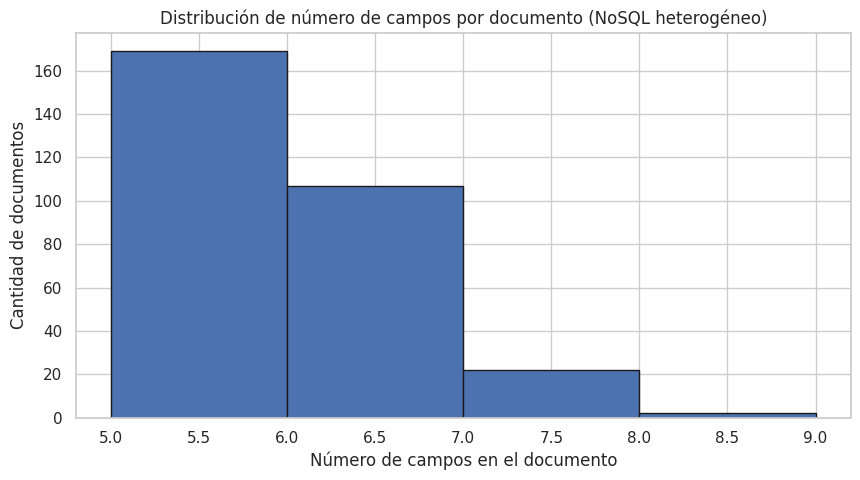

In [10]:
# Contar cuántas claves tiene cada documento (simula "densidad" de cada doc)
num_keys = [len(d.keys()) for d in docs_hetero]
pd.Series(num_keys).describe().round(2)

# Histograma: cuántas claves por documento
plt.figure()
plt.hist(num_keys, bins=range(min(num_keys), max(num_keys)+2), edgecolor="k")
plt.xlabel("Número de campos en el documento")
plt.ylabel("Cantidad de documentos")
plt.title("Distribución de número de campos por documento (NoSQL heterogéneo)")
plt.show()


## 3) NoSQL homogéneo (misma estructura por documento, sin esquema rígido)
Analogía: **una baraja donde todas las cartas tienen los mismos campos**, pero esos campos pueden contener listas, objetos anidados o faltar en algunos casos — la "ficha" no está impresa pero todos usan el mismo diseño flexible.
Vamos a generar documentos con la misma estructura (incluyendo campos anidados).


In [11]:
# Crear documentos homogéneos: todos tienen las mismas claves (posible contenido anidado)
docs_uniform = []
for i in range(1, n+1):
    doc = {
        "id": i,
        "title": f"Uniform_{i}",
        "category": np.random.choice(categories, p=cat_probs),
        "episodes": int(np.random.choice(episodes)),  # reusar valores para variedad
        "rating": float(np.clip(np.random.normal(7.0, 0.9), 1.0, 10.0)),
        "meta": {
            "studio": np.random.choice(["Studio A","Studio B","Studio C","Indie"]),
            "year": int(np.random.randint(1980, 2023)),
            "awards": int(np.random.poisson(0.3))
        }
    }
    docs_uniform.append(doc)

# Normalizamos (aplanar) para análisis tabular
df_uniform = pd.json_normalize(docs_uniform, sep="_")
display(df_uniform.head())
df_uniform.info()


,id,title,category,episodes,rating,meta_studio,meta_year,meta_awards
0,1,Uniform_1,SliceOfLife,39,7.470019,Studio A,2016,1
1,2,Uniform_2,SliceOfLife,55,6.265236,Studio B,1988,0
2,3,Uniform_3,Sports,1566,4.817307,Indie,2020,0
3,4,Uniform_4,Action,12,6.972846,Studio B,2014,0
4,5,Uniform_5,Action,156,8.111610,Studio C,1981,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           300 non-null    int64  
 1   title        300 non-null    object 
 2   category     300 non-null    object 
 3   episodes     300 non-null    int64  
 4   rating       300 non-null    float64
 5   meta_studio  300 non-null    object 
 6   meta_year    300 non-null    int64  
 7   meta_awards  300 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 18.9+ KB


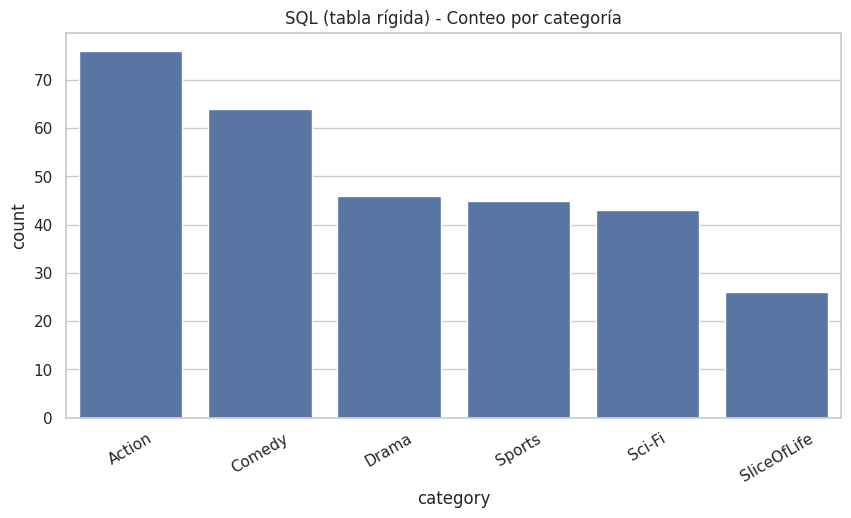

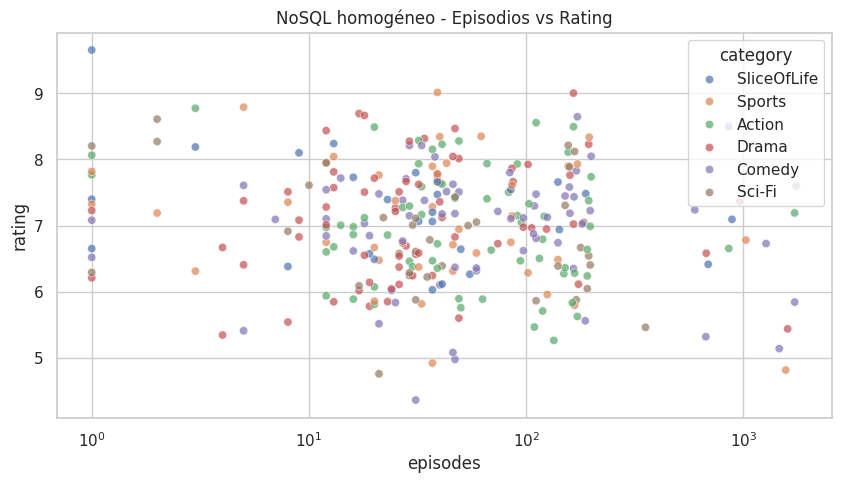

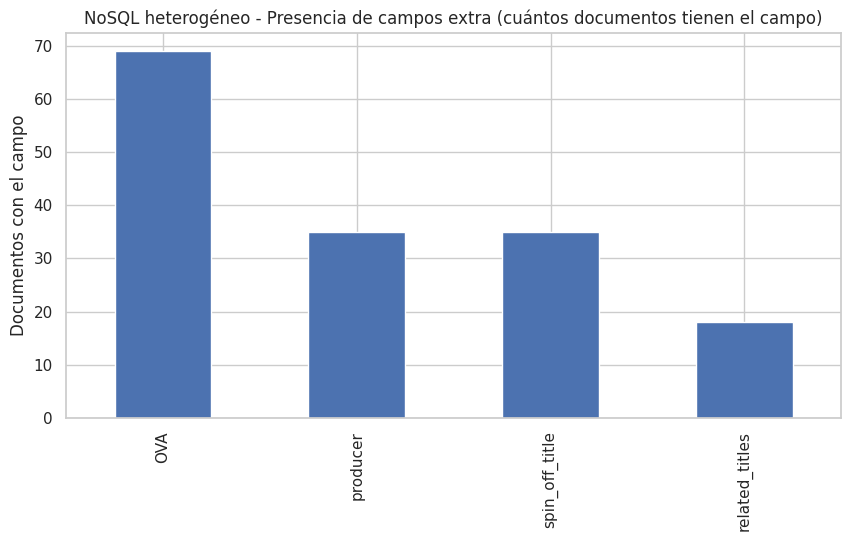

In [12]:
# 1) SQL: conteo por categoría (barras)
plt.figure()
sns.countplot(data=df_sql, x="category", order=df_sql['category'].value_counts().index)
plt.title("SQL (tabla rígida) - Conteo por categoría")
plt.xticks(rotation=30)
plt.show()

# 2) NoSQL homogéneo: scatter episodes vs rating
plt.figure()
sns.scatterplot(data=df_uniform, x="episodes", y="rating", hue="category", alpha=0.7)
plt.title("NoSQL homogéneo - Episodios vs Rating")
plt.xscale('log')  # escala log para facilitar lectura si hay outliers largos
plt.show()

# 3) NoSQL heterogéneo: presencia de campos extra (barras)
# Contamos presencia de columnas extras en df_docs_hetero
extra_cols = [c for c in df_docs_hetero.columns if c not in df_sql.columns]
presence = df_docs_hetero[extra_cols].notnull().sum().sort_values(ascending=False)
plt.figure()
presence.plot(kind='bar')
plt.title("NoSQL heterogéneo - Presencia de campos extra (cuántos documentos tienen el campo)")
plt.ylabel("Documentos con el campo")
plt.show()


## Interpretación rápida
- **SQL (tabla rígida)**: contamos y agrupamos fácilmente por columnas fijas (categoría, episodios). Es ideal para consultas estructuradas.
- **NoSQL homogéneo**: permite anidar datos (campo `meta`), y sigue siendo fácil de analizar si todos los documentos comparten estructura.
- **NoSQL heterogéneo**: podemos añadir campos muy distintos por documento; la tabla resultante (al normalizar) tiene muchas columnas opcionales y huecos (NULL). Es flexible pero puede ser más costoso de casar para ciertos análisis.


## Ejemplo práctico: añadir un nuevo atributo "spin_off" en cada modelo
- En **SQL**: se necesita alterar el esquema (conceptualmente); aquí lo vemos como una nueva columna con NULLs en filas antiguas.
- En **NoSQL heterogéneo**: basta con agregarlo a los documentos que lo tengan; no se toca el esquema global.
- En **NoSQL homogéneo**: podemos decidir agregar la clave a todos los documentos o sólo a algunos (sigue siendo flexible).


In [13]:
# SQL (DataFrame) -> nueva columna (NULLs)
df_sql_new = df_sql.copy()
df_sql_new['spin_off'] = np.nan
print("SQL: columna 'spin_off' añadida, muestra:")
display(df_sql_new.head())

# NoSQL heterogéneo -> añadir 'spin_off' a algunos documentos
docs_hetero2 = [d.copy() for d in docs_hetero]
for i, d in enumerate(docs_hetero2):
    if i % 10 == 0:  # solo al 10% le añadimos spin_off
        d['spin_off'] = f"{d['title']} - Spin"
print("\nNoSQL heterogéneo: documento ejemplo con spin_off añadido (si corresponde):")
for d in docs_hetero2[:5]:
    print(d)

# NoSQL homogéneo -> añadimos el campo a todos los documentos
docs_uniform2 = []
for d in docs_uniform:
    d2 = d.copy()
    d2['spin_off'] = np.random.choice([None, f"{d['title']} Side"], p=[0.85,0.15])
    docs_uniform2.append(d2)
print("\nNoSQL homogéneo: todos los documentos tienen la clave 'spin_off' (puede ser None).")


SQL: columna 'spin_off' añadida, muestra:


,id,title,category,episodes,rating,members,spin_off
0,1,Anime_1,Action,45,7.31,261910,NaN
1,2,Anime_2,Comedy,1192,8.72,1072812,NaN
2,3,Anime_3,Drama,166,7.29,88955,NaN
3,4,Anime_4,Sci-Fi,30,7.17,1790450,NaN
4,5,Anime_5,Sports,47,8.44,628433,NaN



NoSQL heterogéneo: documento ejemplo con spin_off añadido (si corresponde):
{'id': 190, 'title': 'Anime_190', 'episodes': 29, 'rating': 8.66, 'category': 'Comedy', 'spin_off': 'Anime_190 - Spin'}
{'id': 124, 'title': 'Anime_124', 'episodes': 49, 'rating': 9.36, 'category': 'Sports', 'producer': np.str_('Studio A')}
{'id': 186, 'title': 'Anime_186', 'episodes': 77, 'rating': 7.65, 'category': 'Action'}
{'id': 214, 'title': 'Anime_214', 'episodes': 20, 'rating': 7.18, 'category': 'Comedy'}
{'id': 107, 'title': 'Anime_107', 'episodes': 29, 'rating': 5.63, 'category': 'Action'}

NoSQL homogéneo: todos los documentos tienen la clave 'spin_off' (puede ser None).


## Conclusión comparativa (resumen simple)
- **SQL (esquema rígido)**: bueno para datos bien estructurados y consitentes. Ideal cuando necesitas integridad, joins y consultas complejas. Menos flexible ante cambios frecuentes de campos.
- **NoSQL documental (heterogéneo)**: muy flexible; perfecto cuando los registros pueden variar mucho entre sí. Complica un poco el análisis tabular porque las "columnas" emergen y aparecen huecos.
- **NoSQL homogéneo**: balance entre flexibilidad y orden: documentos pueden contener estructuras ricas (listas, objetos), pero si todos siguen la misma forma, el análisis sigue siendo fácil.

**Analogía final:**  
- SQL = hojas impresas idénticas (un formulario para todos).  
- NoSQL heterogéneo = cartas distintas en una baraja, cada carta puede traer campos únicos.  
- NoSQL homogéneo = cartas con el mismo diseño pero con bolsillos para notas y objetos (flexible pero uniforme).

Ventaja rápida: si cambias mucho los campos, NoSQL te salva tiempo; si necesitas transacciones y relaciones complejas, SQL sigue siendo más claro y seguro.
